In [1]:
import datetime
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import torch
import torch.utils.data as Data
import tqdm
from torch import nn

2024-02-10 22:52:02.214998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-10 22:52:02.257850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 22:52:02.257885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 22:52:02.259421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 22:52:02.268338: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Setup Project Parameters
DataAugmentation, DataAugThreshold = True, 30000
DataFilePath, DataFileName, FileType = "autodl-tmp/Multitriage/Data/powershell", "Issueazure-powershellWebScrap", ".csv"
MAX_SEQUENCE_LENGTH, EMBEDDING_DIM = 300, 100
HIDDEN_DIM, LAYER_DIM = 50, 1
LoadDataAugFromFile = False
LearningRate = 0.001
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCH = 25

In [3]:
# log file
filename = 'Log/Multimodel' + '_' + DataFileName + ('_dataaug' if DataAugmentation else '') + '_' + str(LearningRate) + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(EMBEDDING_DIM) 
filelog = open(filename + ".txt", "w")
filelog.write("StartTime:" + str(datetime.datetime.now()))
filelog.close()

In [4]:
# get traindata & testdata
trainpath = "Data/powershell/C_uA_Train.csv"
testapth = "Data/powershell/C_uA_Test.csv"
traindata = pd.read_csv(trainpath,
                                error_bad_lines=False, index_col=False, dtype='unicode', encoding='latin-1',
                                low_memory=False).sample(frac=1)
traindata = traindata.rename(columns={'ï»¿RepoID': 'RepoID'}, inplace=False)
testdata = pd.read_csv(testapth,
                               error_bad_lines=False, index_col=False, dtype='unicode', encoding='latin-1',
                               low_memory=False).sample(frac=1)
testdata = testdata.rename(columns={'ï»¿RepoID': 'RepoID'}, inplace=False)

In [5]:
def RemoveTestRecordIfNotExistInTrainData(traindata, testdata):
    traingroup = traindata.groupby(["Name", "FixedByID"], as_index=True)["FixedByID"].size().reset_index(name="count")
    testgroup = testdata.groupby(["Name", "FixedByID"], as_index=True)["FixedByID"].size().reset_index(name="count")
    for ind in testgroup.index:
        try:
            record = traindata[
                traindata['FixedByID'].str.match(testgroup['FixedByID'][ind]) & traindata['Name'].str.match(
                    testgroup['Name'][ind])]
            if len(record) < 1:
                print('remove from testdata...')
                testdata = testdata.drop(testdata[
                                             testdata['FixedByID'].str.match(testgroup['FixedByID'][ind]) & testdata[
                                                 'Name'].str.match(testgroup['Name'][ind])].index)
        except:
            print("An exception occurred index :", ind)
    return testdata
# testdata = RemoveTestRecordIfNotExistInTrainData(traindata, testdata)

* 提取训练测试集的输入输出
* X: 很多AST不存在

In [6]:
# extract Input&Output in train&test dataset
train_dev_y, test_dev_y = list(traindata['FixedByID']), list(testdata['FixedByID'])  # Developer List
train_btype_y, test_btype_y = list(traindata['Name']), list(testdata['Name'])  # Bug Type List
# traindata.AST = traindata.AST.astype(str)
x_train_context, x_test_context = list(traindata['Title_Description']), list(testdata['Title_Description'])
x_train_AST, x_test_AST = list(traindata['AST']), list(testdata['AST'])

* train_dev_y, test_dev_y转为独热向量dev_y_train, dev_y_test
* 将train_btype_y, test_btype_y转为独热向量btype_y_train, btype_y_test

In [7]:
# 为每个label建立多点独热向量
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

# 按照tagname处理mapping_csv
def create_tag_mapping(mapping_csv, tagname):
    '''
    return:
        labels_map[i] 为'labels'中第i个标签
        inv_lables_map[标签] 为标签在'labels'中的序号
        列表'IssueType_Tags'存每一项(多个标签)对应的独热向量
    '''
    # tagname FixedByID
    print('mapping_csv\'s len: ', len(mapping_csv), ', tagname:', tagname)
    # create a set of all known tags
    labels, IssueType_Tags = set(), []
    for i in range(len(mapping_csv)):    # 集合'labels'存所有标签
        tags = mapping_csv[i].split('|')
        labels.update(tags)
    labels = list(labels)
    labels.sort()    # 将集合'labels'转为有序LIST
    labels_map = {labels[i]: i for i in range(len(labels))}   # labels_map[i] 为'labels'中第i个标签
    inv_labels_map = {i: labels[i] for i in range(len(labels))}    # inv_lables_map[标签] 为标签在'labels'中的序号
    for i in range(len(mapping_csv)):
        # Create One Hot Encoding For Issue Type
        IssueType_Tag = one_hot_encode(mapping_csv[i].split('|'), labels_map) # (*func7*) one_hot_encode
        IssueType_Tags.append(IssueType_Tag)    # 列表'IssueType_Tags'存每一项(多个标签)对应的独热向量
    result = IssueType_Tags
    return labels_map, inv_labels_map, result

# /*******************将train_dev_y, test_dev_y转为独热向量dev_y_train, dev_y_test***********************/
dev_labels_map, dev_inv_labels_map, combineddata_dev_enc = create_tag_mapping(train_dev_y + test_dev_y, 'FixedByID')
dev_y_train = combineddata_dev_enc[:len(train_dev_y)]
dev_y_test = combineddata_dev_enc[len(train_dev_y):]
# 31929 1430 33359
print("    Developer: ", "Training(", len(train_dev_y),  "), Testing(", len(test_dev_y), "), Combined DEV + TEST(",
        len(combineddata_dev_enc), ')')

# /*******************将train_btype_y, test_btype_y转为独热向量btype_y_train, btype_y_test***********************/
btype_labels_map, btype_inv_labels_map, combineddata_bugtype_enc = create_tag_mapping(train_btype_y + test_btype_y, 'Name')
btype_y_train = combineddata_bugtype_enc[:len(train_btype_y)]
btype_y_test = combineddata_bugtype_enc[len(train_btype_y):]
print("    Bug Type: ", "Training:(", len(btype_y_train), "), Testing(", len(btype_y_test), "), Combined DEV + TEST(",
        len(combineddata_bugtype_enc), ')')

mapping_csv's len:  2540 , tagname: FixedByID
    Developer:  Training( 2032 ), Testing( 508 ), Combined DEV + TEST( 2540 )
mapping_csv's len:  2540 , tagname: Name
    Bug Type:  Training:( 2032 ), Testing( 508 ), Combined DEV + TEST( 2540 )


* x_train/test_context/AST -tokenizer-text2seq-> x_train/test_context/AST_sequences
* 使用keras.preprocessing.text.Tokenizer进行分词
* ？: Byte Pair Encoding(BPE)法/transformers.BertTokenizer

In [8]:
# /*******************Tokenizer****************************/
# INPUT: context 小写后 转为 toeknizer 
x_train_context, x_test_context = [str(row).lower() for row in x_train_context], [str(row).lower() for row in x_test_context]
combineddata_context = x_train_context + x_test_context
# 不限词汇表大小，以单词为单位，未知词标为Unknown，过滤掉'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\d+'
tk_context = Tokenizer(num_words=None, char_level=None, oov_token='Unknown',
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tk_context.fit_on_texts(combineddata_context)
x_train_context_sequences = tk_context.texts_to_sequences(x_train_context)
x_test_context_sequences = tk_context.texts_to_sequences(x_test_context)

# /*******************Tokenizer****************************/
x_train_AST, x_test_AST = [str(row).lower() for row in x_train_AST], [str(row).lower() for row in x_test_AST]
combineddata_AST = x_train_AST + x_test_AST
tk_AST = Tokenizer(num_words=None, char_level=None, oov_token='Unknown')
tk_AST.fit_on_texts(combineddata_AST)
x_train_AST_sequences = tk_AST.texts_to_sequences(x_train_AST)
x_test_AST_sequences = tk_AST.texts_to_sequences(x_test_AST)

* 在序列后填充0到MAX_SEQUENCE_LENGTH -> ndarray -> tensor
* X：太多的零信息损失

In [9]:
# 在序列后填充0到MAX_SEQUENCE_LENGTH
x_train_context = pad_sequences(x_train_context_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_train_AST = pad_sequences(x_train_AST_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test_context = pad_sequences(x_test_context_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test_AST = pad_sequences(x_test_AST_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Convert to numpy array
x_train_context, x_test_context = torch.from_numpy(np.array(x_train_context).astype(np.float32)), torch.from_numpy(np.array(x_test_context).astype(np.float32))    # Input:context
x_train_AST, x_test_AST = torch.from_numpy(np.array(x_train_AST).astype(np.float32)), torch.from_numpy(np.array(x_test_AST).astype(np.float32))    # Input:AST

noofbugtype, noofdev = len(btype_labels_map), len(dev_labels_map)    # Output size
btype_y_train, btype_y_test = torch.from_numpy(np.array(btype_y_train).astype(np.float32)), torch.from_numpy(np.array(btype_y_test).astype(np.float32))    # Output: btype
dev_y_train, dev_y_test = torch.from_numpy(np.array(dev_y_train).astype(np.float32)) , torch.from_numpy(np.array(dev_y_test).astype(np.float32))    # Output: dev

In [38]:
train_dataset = Data.TensorDataset(torch.cat((x_train_context, x_train_AST), dim=1), torch.cat((btype_y_train, dev_y_train), dim=1))
dataloader = Data.DataLoader(
    dataset = train_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True)

In [45]:
import torch.nn.functional as F
class MTModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim):
        '''
        vocab_size: [vocab_size_context, vocab_size_AST], [len(tk_context.word_index) + 2, len(tk_AST.word_index) + 2]
        embedding_dim: EMBEDDING_DIM
        hidden_dim: HIDDEN_DIM
        layer_dim: LAYER_DIM
        '''
        super(MTModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim    #LSTM神经元个数
        self.layer_dim = layer_dim    

        self.emb_C = nn.Embedding(vocab_size[0], embedding_dim)
        self.conv_C = nn.Conv1d(MAX_SEQUENCE_LENGTH, 64, 2)
        
        self.emb_A = nn.Embedding(vocab_size[1], embedding_dim)
        self.lstm_A = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=layer_dim, bidirectional=True)

        self.fc_DB = nn.Linear(114, 50) 
        self.fc_D = nn.Linear(50, noofdev)  
        self.fc_B = nn.Linear(50, noofbugtype) 

    def forward(self, x1, x2):
        x1 = self.emb_C(x1)
        x1 = F.relu(self.conv_C(x1))
        x1 = nn.AdaptiveMaxPool1d(1)(x1)
        x1 = torch.flatten(x1, 1)

        x2 = self.emb_A(x2)
        x2, _ = self.lstm_A(x2)
        x2 = nn.AdaptiveMaxPool1d(1)(torch.transpose(x2, 1, 2))
        x2 = torch.flatten(x2, 1)

        x = torch.cat((x1, x2), dim=1)
        x = nn.BatchNorm1d(114)(x)
        x = self.fc_DB(nn.Dropout(0.5)(x))
        y1 = nn.Sigmoid()(self.fc_D(x))
        y2 = nn.Sigmoid()(self.fc_B(x))
        return y1, y2

In [46]:
mtmodel = MTModel(
        [len(tk_context.word_index) + 2, len(tk_AST.word_index) + 2], 
        EMBEDDING_DIM, HIDDEN_DIM, LAYER_DIM)
print([len(tk_context.word_index) + 2, len(tk_AST.word_index) + 2])
optimizer = torch.optim.Adam(mtmodel.parameters(),lr=0.001)  
loss_func = nn.BCEWithLogitsLoss()

[12516, 5913]


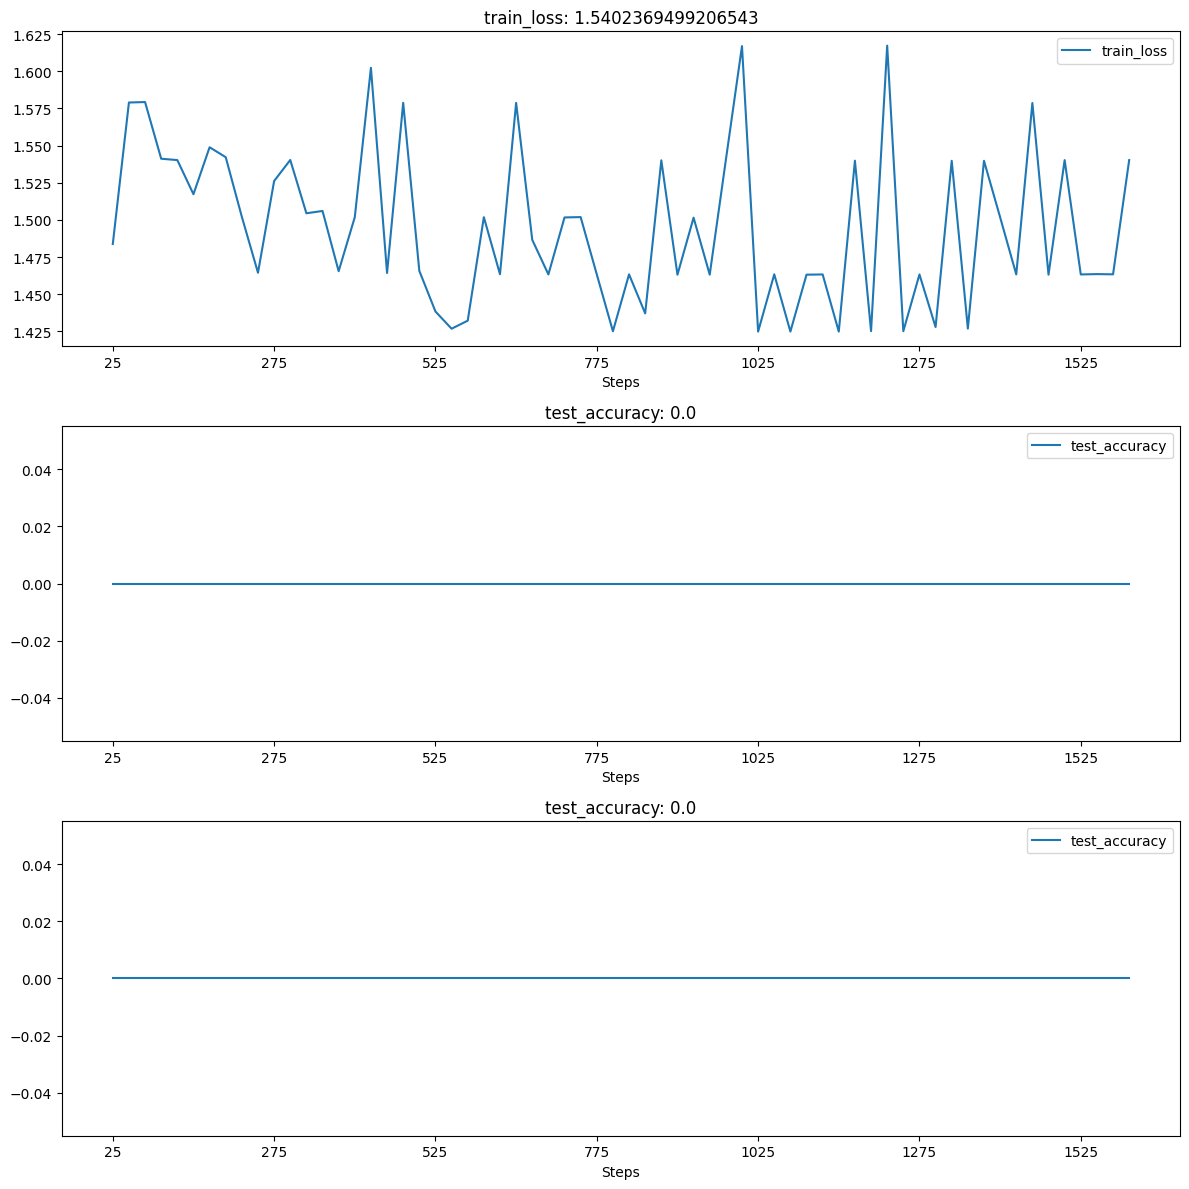

100%|██████████| 25/25 [01:15<00:00,  3.00s/it]


In [51]:
import hiddenlayer as hl
from sklearn.metrics import accuracy_score
history1 = hl.History()
history2 = hl.History()
canvas1 = hl.Canvas()
print_step = 25

for epoch in tqdm.trange(EPOCH):
    for step, (b_x, b_y) in enumerate(dataloader):  
        b_x1, b_x2 = b_x[:, :300], b_x[:, 300:]
        b_y1, b_y2 = b_y[:, :noofdev], b_y[:, noofdev:]
        y1, y2 = mtmodel(b_x1.long(), b_x2.long())  
        train_loss = loss_func(y1, b_y1) + loss_func(y2, b_y2)
        optimizer.zero_grad()        
        train_loss.backward()         
        optimizer.step()                
        niter = epoch*len(dataloader)+step+1
        
        if niter % print_step == 0:
            y1, y2 = mtmodel(x_test_context.long(), x_test_AST.long())
            y1, y2 = (y1 > 0.5).float(), (y2 > 0.5).float()
            test_accuracy1 = accuracy_score(dev_y_test,y1)
            test_accuracy2 = accuracy_score(btype_y_test,y2)
            history1.log(niter, train_loss=train_loss, 
                        test_accuracy=test_accuracy1)
            history2.log(niter, train_loss=train_loss, 
                        test_accuracy=test_accuracy2)
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])
                canvas1.draw_plot(history2["test_accuracy"])

In [30]:
mtmodel(x_test_context.long(), x_test_AST.long())

(tensor([[7.5621e-20, 1.9146e-19, 1.5667e-19,  ..., 4.9332e-20, 8.8187e-21,
          4.9004e-21],
         [7.1922e-23, 4.1246e-22, 3.6125e-22,  ..., 6.2392e-23, 2.1508e-23,
          5.6099e-24],
         [1.5129e-15, 2.5829e-15, 3.8511e-15,  ..., 1.2480e-15, 4.1040e-16,
          2.4242e-16],
         ...,
         [4.3845e-17, 1.6647e-16, 2.0331e-16,  ..., 6.0183e-17, 3.3073e-17,
          1.0433e-17],
         [8.3865e-20, 3.1791e-19, 4.2916e-19,  ..., 6.4720e-20, 2.4188e-20,
          6.8744e-21],
         [5.0181e-19, 1.4585e-18, 2.6962e-18,  ..., 3.7668e-19, 1.6548e-19,
          1.2275e-19]], grad_fn=<SigmoidBackward0>),
 tensor([[5.0503e-19, 7.2628e-20, 7.2207e-21,  ..., 4.6294e-20, 1.7646e-18,
          7.2113e-20],
         [6.4734e-22, 1.2802e-22, 5.3485e-24,  ..., 3.2832e-23, 4.8162e-21,
          5.1485e-23],
         [4.7548e-15, 1.6133e-15, 2.2173e-16,  ..., 9.1837e-16, 1.5084e-14,
          7.7184e-16],
         ...,
         [3.8396e-16, 1.0917e-16, 1.3069e-17,  ...,

In [23]:
dev_y_test, btype_y_test

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))